In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# --- 設定 ---
# 建立儲存圖片的資料夾
SAVE_DIR = "tsne_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

def visualize_dataset(name):
    print(f"Processing {name}...")
    
    # 1. 加載數據 (NormalizeFeatures 對 t-SNE 效果比較好)
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=T.NormalizeFeatures())
    data = dataset[0]
    
    X = data.x.numpy()
    y = data.y.numpy()
    
    # 2. 執行 t-SNE
    # init='pca' 可以讓結果更穩定，n_jobs=-1 用盡 server 所有 CPU
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', n_jobs=10)
    X_embedded = tsne.fit_transform(X)
    
    # 3. 畫圖 (Layout 優化)
    plt.figure(figsize=(10, 10), dpi=300) # 高解析度
    
    # 繪製散點
    # alpha=0.6 增加透明度以觀察重疊，s=10 設定點的大小
    # cmap='tab10' 提供清晰的分類顏色
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', s=14, alpha=0.8)
    
    # 4. Layout 清潔化 (Remove clutter)
    # 移除座標軸與邊框 (因為 t-SNE 的座標數值無物理意義)
    plt.axis('off')
    
    # 加上標題與圖例
    plt.title(f"{name} (t-SNE)", fontsize=16, fontweight='bold', pad=20)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right", frameon=True, framealpha=0.9)
    
    # 5. 存檔
    save_path = os.path.join(SAVE_DIR, f"{name}_tsne.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close() # 關閉圖形以釋放記憶體
    
    print(f"  -> Saved to {save_path}")

# --- 執行 ---
datasets = ['Cora', 'CiteSeer', 'PubMed']

for name in datasets:
    visualize_dataset(name)

print("\nDone. Check the 'tsne_plots' folder.")

Processing Cora...
  -> Saved to tsne_plots/Cora_tsne.png
Processing CiteSeer...
  -> Saved to tsne_plots/CiteSeer_tsne.png
Processing PubMed...
  -> Saved to tsne_plots/PubMed_tsne.png

Done. Check the 'tsne_plots' folder.


Analyzing Cora...


/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


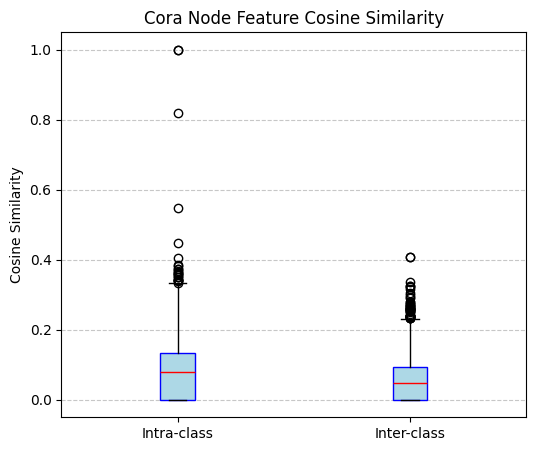

  -> Avg Intra-class Similarity: 0.0840
  -> Avg Inter-class Similarity: 0.0544
------------------------------
Analyzing CiteSeer...


Processing...
Processing...
Done!
Done!
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


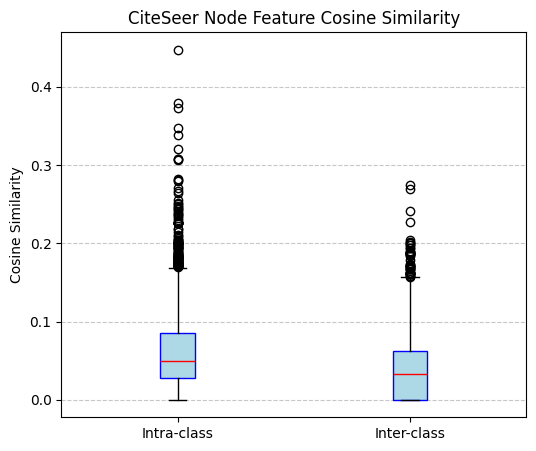

  -> Avg Intra-class Similarity: 0.0568
  -> Avg Inter-class Similarity: 0.0404
------------------------------
Analyzing PubMed...


Processing...
Processing...
Done!
Done!
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


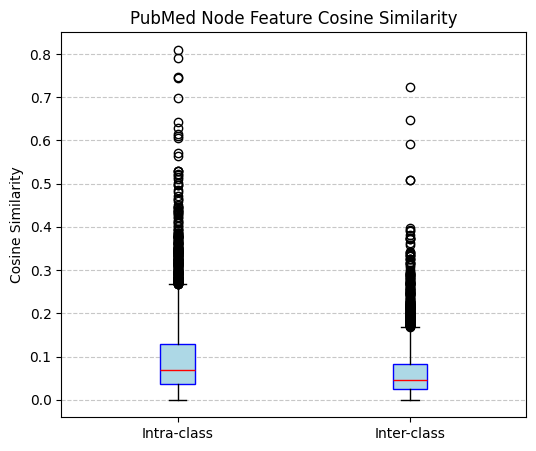

  -> Avg Intra-class Similarity: 0.0946
  -> Avg Inter-class Similarity: 0.0613
------------------------------


In [ ]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import numpy as np

def analyze_class_feature_similarity(name):
    print(f"Analyzing {name}...")
    # 1. 加載數據
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=T.NormalizeFeatures())
    data = dataset[0]
    x = data.x
    y = data.y
    
    # L2 Normalize features so that dot product == cosine similarity
    # NormalizeFeatures 做的是 L1 norm (sum=1)，計算 Cosine Similarity 需要 L2 norm
    x = torch.nn.functional.normalize(x, p=2, dim=1)
    
    classes = torch.unique(y).numpy()
    class_sims_mean = []
    class_sims_std = []
    
    print(f"  Computing pairwise similarities for {len(classes)} classes...")
    
    for c in classes:
        # 提取該類別的所有節點特徵
        mask = (y == torch.tensor(c))
        x_c = x[mask]
        
        if x_c.size(0) < 2:
            class_sims_mean.append(0)
            class_sims_std.append(0)
            continue
            
        # 計算兩兩相似度矩陣 (N_c x N_c)
        # 因為已經做了 L2 normalization，矩陣乘法即為 Cosine Similarity
        sim_matrix = torch.mm(x_c, x_c.t())
        
        # 取上三角矩陣 (不包含對角線)，即所有不重複的兩兩配對
        rows, cols = torch.triu_indices(x_c.size(0), x_c.size(0), offset=1)
        
        if len(rows) > 0:
            sims = sim_matrix[rows, cols]
            class_sims_mean.append(sims.mean().item())
            class_sims_std.append(sims.std().item())
        else:
            class_sims_mean.append(0)
            class_sims_std.append(0)

    # 4. 畫圖 (Bar Chart)
    plt.figure(figsize=(10, 6))
    
    # 繪製柱狀圖
    x_pos = np.arange(len(classes))
    # yerr 顯示標準差，觀察分佈的離散程度
    bars = plt.bar(x_pos, class_sims_mean, yerr=class_sims_std, align='center', alpha=0.7, ecolor='black', capsize=10, color='skyblue')
    
    plt.xlabel('Class ID')
    plt.ylabel('Average Cosine Similarity')
    plt.title(f'{name} Intra-class Feature Cosine Similarity')
    plt.xticks(x_pos, classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.0) # Cosine similarity range [0, 1] usually for non-negative features
    
    # 在柱狀圖上方標示數值
    for bar, v in zip(bars, class_sims_mean):
        plt.text(bar.get_x() + bar.get_width() / 2, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
        
    plt.show()
    
    print(f"  -> Class Means: {['{:.3f}'.format(x) for x in class_sims_mean]}")
    print("-" * 30)

# --- 執行 ---
datasets = ['Cora', 'CiteSeer', 'PubMed']
for name in datasets:
    analyze_class_feature_similarity(name)

In [2]:
import torch
from torch_geometric.datasets import Reddit
from ogb.nodeproppred import PygNodePropPredDataset
import numpy as np
from torch_geometric.utils import degree
import torch_geometric.transforms as T

def analyze_graph_statistics(name, dataset):
    print(f"Analyzing {name}...")
    data = dataset[0]
    
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_features
    
    # Handle classes
    if hasattr(data, 'y') and data.y is not None:
        # Check for NaN values in y (common in OGB)
        y_clean = data.y[~torch.isnan(data.y)]
        if data.y.dim() > 1 and data.y.shape[1] > 1:
             # Multi-label
             num_classes = data.y.shape[1]
        else:
             num_classes = len(torch.unique(y_clean))
    else:
        num_classes = "N/A"

    # Check directionality
    is_undirected = data.is_undirected()
    
    # Calculate degrees
    # degree() computes in-degree if using edge_index[1] or out-degree if edge_index[0]
    # For undirected graphs represented with bidirectional edges, this gives the degree.
    d = degree(data.edge_index[0], num_nodes=num_nodes)
    avg_degree = d.mean().item()
    max_degree = d.max().item()
    min_degree = d.min().item()
    
    # Density: E / (N * (N-1)) for directed, 2E / (N * (N-1)) for undirected (if E is unique pairs)
    # Since PyG stores undirected as 2 directed edges, num_edges is 2*|E|.
    # So density = num_edges / (N * (N-1)) works for both cases roughly.
    density = num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    print(f"  Nodes: {num_nodes:,}")
    print(f"  Edges: {num_edges:,}")
    print(f"  Features: {num_features}")
    print(f"  Classes: {num_classes}")
    print(f"  Is Undirected: {is_undirected}")
    print(f"  Average Degree: {avg_degree:.4f}")
    print(f"  Max Degree: {max_degree:.4f}")
    print(f"  Min Degree: {min_degree:.4f}")
    print(f"  Density: {density:.6f}")
    print("-" * 30)

# Ogbn-arxiv
# Arxiv is a directed citation graph.
try:
    print("Loading ogbn-arxiv...")
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    # To analyze it as an undirected graph (co-citation/collaboration style view), we can transform it, 
    # but usually we analyze the raw graph first.
    analyze_graph_statistics('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Error loading ogbn-arxiv: {e}")

# Reddit
try:
    print("Loading Reddit...")
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_graph_statistics('Reddit', dataset_reddit)
except Exception as e:
    print(f"Error loading Reddit: {e}")

Loading ogbn-arxiv...
Analyzing ogbn-arxiv...
  Nodes: 169,343
  Edges: 1,166,243
  Features: 128
  Classes: 40
  Is Undirected: False
  Average Degree: 6.8869
  Max Degree: 436.0000
  Min Degree: 0.0000
  Density: 0.000041
------------------------------
Loading Reddit...
Analyzing Reddit...
Analyzing Reddit...
  Nodes: 232,965
  Edges: 114,615,892
  Features: 602
  Classes: 41
  Is Undirected: True
  Average Degree: 491.9876
  Max Degree: 21657.0000
  Min Degree: 1.0000
  Density: 0.002112
------------------------------
  Nodes: 232,965
  Edges: 114,615,892
  Features: 602
  Classes: 41
  Is Undirected: True
  Average Degree: 491.9876
  Max Degree: 21657.0000
  Min Degree: 1.0000
  Density: 0.002112
------------------------------


In [1]:
import torch
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset
import torch_geometric.transforms as T

def analyze_isolation_and_direction(name, dataset):
    data = dataset[0]
    
    # Check direction
    is_undirected = data.is_undirected()
    direction_status = "Undirected" if is_undirected else "Directed"
    
    # Count isolated nodes
    # Nodes that do not appear in edge_index are isolated
    edge_index = data.edge_index
    num_nodes = data.num_nodes
    
    # torch.unique returns sorted unique elements
    connected_nodes = torch.unique(edge_index)
    num_connected = connected_nodes.size(0)
    num_isolated = num_nodes - num_connected
    
    print(f"Dataset: {name}")
    print(f"  Structure: {direction_status}")
    print(f"  Total Nodes: {num_nodes}")
    print(f"  Isolated Nodes: {num_isolated} ({num_isolated/num_nodes*100:.2f}%)")
    print("-" * 30)

# 1. Planetoid Datasets
planetoid_datasets = ['Cora', 'CiteSeer', 'PubMed']
for name in planetoid_datasets:
    print(f"Loading {name}...")
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_isolation_and_direction(name, dataset)

# 2. Ogbn-arxiv
try:
    print("Loading ogbn-arxiv...")
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    analyze_isolation_and_direction('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Error loading ogbn-arxiv: {e}")

# 3. Reddit
try:
    print("Loading Reddit...")
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_isolation_and_direction('Reddit', dataset_reddit)
except Exception as e:
    print(f"Error loading Reddit: {e}")

Loading Cora...
Dataset: Cora
  Structure: Undirected
  Total Nodes: 2708
  Isolated Nodes: 0 (0.00%)
------------------------------
Loading CiteSeer...
Dataset: CiteSeer
  Structure: Undirected
  Total Nodes: 3327
  Isolated Nodes: 48 (1.44%)
------------------------------
Loading PubMed...
Dataset: PubMed
  Structure: Undirected
  Total Nodes: 19717
  Isolated Nodes: 0 (0.00%)
------------------------------
Loading ogbn-arxiv...
Dataset: ogbn-arxiv
  Structure: Directed
  Total Nodes: 169343
  Isolated Nodes: 0 (0.00%)
------------------------------
Loading Reddit...
Dataset: ogbn-arxiv
  Structure: Directed
  Total Nodes: 169343
  Isolated Nodes: 0 (0.00%)
------------------------------
Loading Reddit...
Dataset: Reddit
  Structure: Undirected
  Total Nodes: 232965
  Isolated Nodes: 0 (0.00%)
------------------------------
Dataset: Reddit
  Structure: Undirected
  Total Nodes: 232965
  Isolated Nodes: 0 (0.00%)
------------------------------


Analyzing Cora...
  Edge Homophily: 0.8100
  Class Imbalance Ratio (Max/Min): 4.54


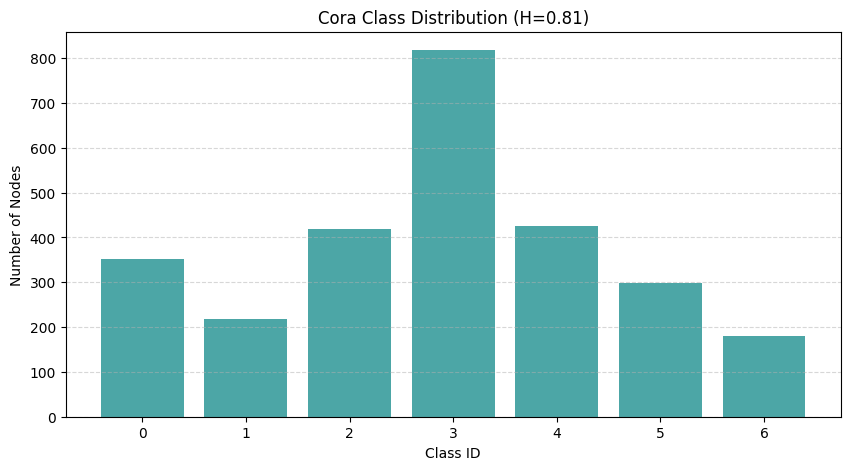

------------------------------
Analyzing CiteSeer...
  Edge Homophily: 0.7355
  Class Imbalance Ratio (Max/Min): 2.66


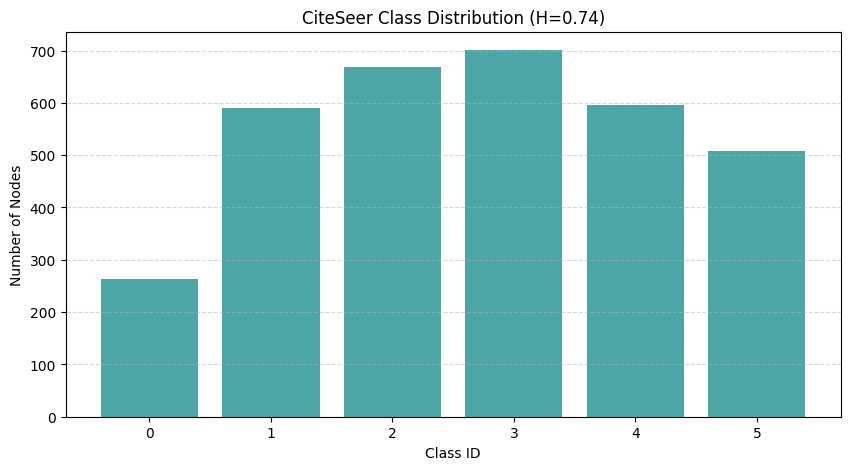

------------------------------
Analyzing PubMed...
  Edge Homophily: 0.8024
  Class Imbalance Ratio (Max/Min): 1.92


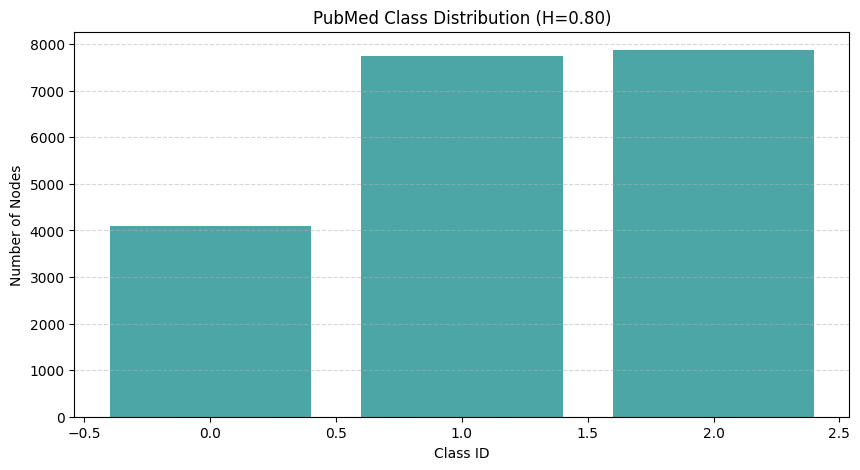

------------------------------
Analyzing ogbn-arxiv...
  Edge Homophily: 0.6551
  Class Imbalance Ratio (Max/Min): 942.10


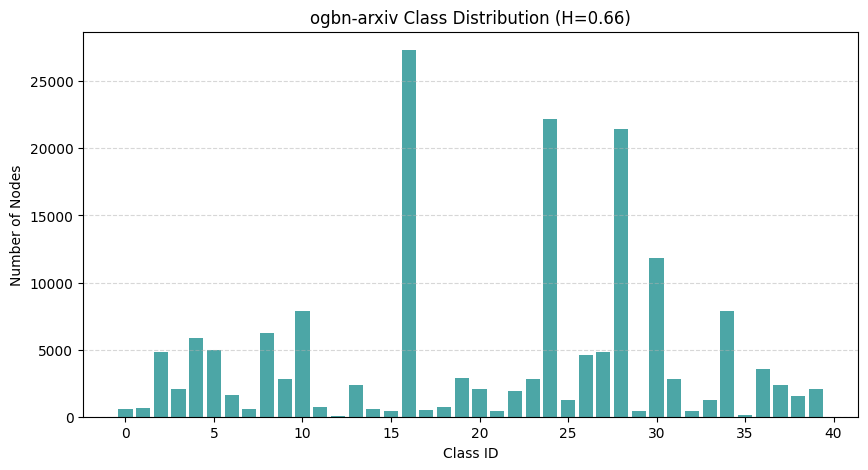

------------------------------
Analyzing Reddit...
Analyzing Reddit...
  Edge Homophily: 0.7555
  Class Imbalance Ratio (Max/Min): 86.20
  Edge Homophily: 0.7555
  Class Imbalance Ratio (Max/Min): 86.20


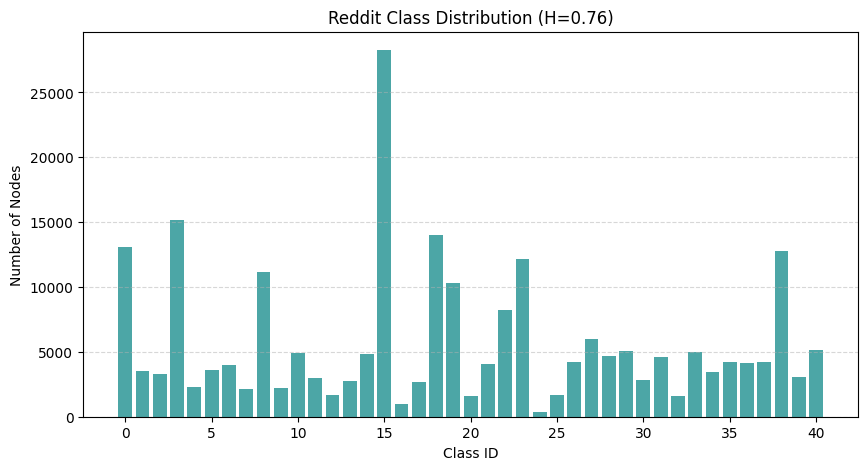

------------------------------


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_homophily_and_balance(name, dataset):
    print(f"Analyzing {name}...")
    data = dataset[0]
    y = data.y
    
    # 處理 OGB 的維度問題 (N, 1) -> (N,)
    if y.dim() > 1 and y.shape[1] == 1:
        y = y.squeeze()
    
    # 1. 計算同質性 (Edge Homophily Ratio)
    # 公式: |{(u,v) in E : y_u == y_v}| / |E|
    edge_index = data.edge_index
    
    # 為了計算準確，確保移除 Self-loops (自己連自己算同類別沒意義)
    mask_no_self_loop = edge_index[0] != edge_index[1]
    src = edge_index[0][mask_no_self_loop]
    dst = edge_index[1][mask_no_self_loop]
    
    # 檢查邊兩端的標籤是否相同
    # 注意：對於部分有 unlabeled nodes 的數據，這裡只計算有標籤的節點
    # 但標準 benchmark 通常全都有標籤 (除了半監督的 mask，但 y 裡通常有值)
    
    # 處理 NaN (OGB 可能有 NaN)
    valid_mask = (~torch.isnan(y[src])) & (~torch.isnan(y[dst]))
    src = src[valid_mask]
    dst = dst[valid_mask]
    
    if src.shape[0] > 0:
        same_class_count = (y[src] == y[dst]).sum().item()
        total_edges = src.shape[0]
        homophily = same_class_count / total_edges
    else:
        homophily = 0.0

    print(f"  Edge Homophily: {homophily:.4f}")
    
    # 2. 類別分佈 (Class Distribution)
    # 移除 NaN
    y_clean = y[~torch.isnan(y)]
    classes, counts = torch.unique(y_clean, return_counts=True)
    classes = classes.numpy()
    counts = counts.numpy()
    
    # 計算不平衡度 (Imbalance Ratio): Max / Min
    imbalance_ratio = counts.max() / counts.min() if counts.min() > 0 else float('inf')
    print(f"  Class Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}")
    
    # 畫圖
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='teal', alpha=0.7)
    plt.xlabel('Class ID')
    plt.ylabel('Number of Nodes')
    plt.title(f'{name} Class Distribution (H={homophily:.2f})')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_homophily_and_balance(name, dataset)

# 2. Ogbn-arxiv
try:
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    analyze_homophily_and_balance('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Skip Arxiv: {e}")

# 3. Reddit
try:
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_homophily_and_balance('Reddit', dataset_reddit)
except Exception as e:
    print(f"Skip Reddit: {e}")

In [3]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx, degree
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_advanced_stats(name, dataset):
    print(f"Analyzing {name}...")
    data = dataset[0]
    num_nodes = data.num_nodes
    
    # 1. Average Degree
    # degree() computes in-degree if using edge_index[1] or out-degree if edge_index[0]
    # For undirected graphs, PyG stores edges in both directions, so we divide by 2 if we sum degrees,
    # but degree() on one index gives the correct degree for that node.
    d = degree(data.edge_index[0], num_nodes=num_nodes)
    avg_degree = d.mean().item()
    print(f"  Average Degree: {avg_degree:.4f}")
    
    # 2. Clustering Coefficient & Diameter (Requires NetworkX)
    # Converting large graphs to NetworkX is slow, so we skip for Reddit/Arxiv if too large
    if num_nodes > 20000:
        print(f"  Skipping NetworkX stats (Graph too large: {num_nodes} nodes)")
    else:
        print("  Converting to NetworkX for advanced stats...")
        # to_networkx converts to directed by default if is_undirected is False
        # For diameter calculation on undirected graphs, we usually treat it as undirected
        G = to_networkx(data, to_undirected=True)
        
        # Clustering Coefficient (Average)
        # Measures the degree to which nodes tend to cluster together
        avg_clustering = nx.average_clustering(G)
        print(f"  Avg Clustering Coefficient: {avg_clustering:.4f}")
        
        # Diameter
        # The maximum eccentricity (longest shortest path)
        # Only defined for connected graphs. If disconnected, we take the diameter of the largest component.
        if nx.is_connected(G):
            diam = nx.diameter(G)
            print(f"  Diameter: {diam}")
        else:
            print("  Graph is not connected.")
            # Get largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            G_sub = G.subgraph(largest_cc)
            diam = nx.diameter(G_sub)
            print(f"  Diameter (Largest Component): {diam}")
            
    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_advanced_stats(name, dataset)

# 2. Ogbn-arxiv (Large, might skip NetworkX part)
try:
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    analyze_advanced_stats('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Skip Arxiv: {e}")

# 3. Reddit (Very Large, will definitely skip NetworkX part)
try:
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_advanced_stats('Reddit', dataset_reddit)
except Exception as e:
    print(f"Skip Reddit: {e}")

Analyzing Cora...
  Average Degree: 3.8981
  Converting to NetworkX for advanced stats...
  Avg Clustering Coefficient: 0.2407
  Graph is not connected.
  Diameter (Largest Component): 19
------------------------------
Analyzing CiteSeer...
  Average Degree: 2.7364
  Converting to NetworkX for advanced stats...
  Avg Clustering Coefficient: 0.1415
  Graph is not connected.
  Diameter (Largest Component): 19
------------------------------
Analyzing CiteSeer...
  Average Degree: 2.7364
  Converting to NetworkX for advanced stats...
  Avg Clustering Coefficient: 0.1415
  Graph is not connected.
  Diameter (Largest Component): 28
------------------------------
Analyzing PubMed...
  Average Degree: 4.4960
  Converting to NetworkX for advanced stats...
  Diameter (Largest Component): 28
------------------------------
Analyzing PubMed...
  Average Degree: 4.4960
  Converting to NetworkX for advanced stats...
  Avg Clustering Coefficient: 0.0602
  Avg Clustering Coefficient: 0.0602


KeyboardInterrupt: 

In [5]:
import torch
import igraph as ig
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_stats_with_igraph(name, dataset):
    print(f"Analyzing {name} with igraph...")
    data = dataset[0]
    
    # 1. 轉換為 igraph (比 NetworkX 快 10-100 倍)
    # igraph 需要 edge list (list of tuples)
    edge_index = data.edge_index
    num_nodes = data.num_nodes
    
    # 轉為 CPU numpy array 並轉置為 (E, 2)
    edges = edge_index.t().cpu().numpy()
    
    # 建立 igraph 物件
    # directed=False 因為我們通常在無向圖上算這些指標
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    
    # 簡化圖 (移除 self-loops 和重複邊，這對計算直徑很重要)
    g.simplify()
    
    # 2. 計算指標
    # Diameter (直徑)
    # igraph 的 diameter 算法是用 BFS/Dijkstra，C++ 實作，非常快
    # 如果圖不連通，igraph 預設會回傳最大連通子圖的直徑
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    # Average Path Length (平均路徑長度)
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    # Clustering Coefficient (Transitivity)
    # global: 整個圖的平均 (三角形數量 / 可能的三角形數量)
    # local average: 先算每個點的 clustering coef，再取平均 (NetworkX 的算法)
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    # 檢查連通性
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_stats_with_igraph(name, dataset)

# 2. Ogbn-arxiv (現在可以用 igraph 跑了！)
try:
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    analyze_stats_with_igraph('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Skip Arxiv: {e}")

# 3. Reddit (igraph 應該也能扛得住)
try:
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_stats_with_igraph('Reddit', dataset_reddit)
except Exception as e:
    print(f"Skip Reddit: {e}")

Analyzing Cora with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Diameter: 18
  Diameter: 18


KeyboardInterrupt: 

In [6]:
import torch
import igraph as ig
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_stats_with_igraph(name, dataset):
    print(f"Analyzing {name} with igraph...")
    data = dataset[0]
    
    # 1. 轉換為 igraph
    edge_index = data.edge_index
    num_nodes = data.num_nodes
    
    # 轉為 CPU numpy array 並轉置為 (E, 2)
    edges = edge_index.t().cpu().numpy()
    
    # 建立 igraph 物件
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    g.simplify()
    
    # 2. 計算指標
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_stats_with_igraph(name, dataset)

# 2. Ogbn-arxiv
dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
analyze_stats_with_igraph('ogbn-arxiv', dataset_arxiv)

# 3. Reddit
dataset_reddit = Reddit(root='./data/Reddit')
analyze_stats_with_igraph('Reddit', dataset_reddit)

Analyzing Cora with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Diameter: 18
  Avg Path Length: 6.3369
  Avg Clustering Coef: 0.1117
  Is Connected: True
------------------------------
Analyzing ogbn-arxiv with igraph...


KeyboardInterrupt: 

In [7]:
import torch
import igraph as ig
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_stats_with_igraph(name, dataset):
    print(f"Analyzing {name} with igraph...")
    data = dataset[0]
    
    # 1. 轉換為 igraph
    edge_index = data.edge_index
    num_nodes = data.num_nodes
    
    # 轉為 CPU numpy array 並轉置為 (E, 2)
    edges = edge_index.t().cpu().numpy()
    
    # 建立 igraph 物件
    # 這裡必須明確指定 edges，否則如果 edges 是空的或格式不對，可能會導致問題
    # 另外，確保每次都建立新的 Graph 物件
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    g.simplify()
    
    # 2. 計算指標
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    dataset = Planetoid(root=f'./data/{name}', name=name)
    analyze_stats_with_igraph(name, dataset)

# 2. Ogbn-arxiv
# 重新載入 dataset 確保乾淨
dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
analyze_stats_with_igraph('ogbn-arxiv', dataset_arxiv)

# 3. Reddit
# 重新載入 dataset 確保乾淨
dataset_reddit = Reddit(root='./data/Reddit')
analyze_stats_with_igraph('Reddit', dataset_reddit)

Analyzing Cora with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Diameter: 18
  Avg Path Length: 6.3369
  Avg Clustering Coef: 0.1117
  Is Connected: True
----

KeyboardInterrupt: 

In [8]:
import torch
import igraph as ig
import os
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_stats_with_igraph(name, dataset):
    print(f"Analyzing {name} with igraph...")
    data = dataset[0]
    
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    # 加入 Debug 資訊確認載入的資料是否正確
    print(f"  Nodes: {num_nodes}, Edges: {num_edges}")
    
    # 1. 轉換為 igraph
    edge_index = data.edge_index
    
    # 轉為 list of tuples，這是 igraph 最穩定的輸入格式
    # 避免 numpy array 可能造成的解析問題
    edges = edge_index.t().cpu().numpy().tolist()
    
    # 建立 igraph 物件
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    g.simplify()
    
    # 2. 計算指標
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
for name in ['Cora', 'CiteSeer', 'PubMed']:
    # 確保路徑正確
    root_path = os.path.join('data', name)
    dataset = Planetoid(root=root_path, name=name)
    analyze_stats_with_igraph(name, dataset)

# 2. Ogbn-arxiv
dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
analyze_stats_with_igraph('ogbn-arxiv', dataset_arxiv)

# 3. Reddit
dataset_reddit = Reddit(root='./data/Reddit')
analyze_stats_with_igraph('Reddit', dataset_reddit)

Analyzing Cora with igraph...
  Nodes: 2708, Edges: 10556
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Nodes: 3327, Edges: 9104
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Analyzing CiteSeer with igraph...
  Nodes: 3327, Edges: 9104
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed with igraph...
  Nodes: 19717, Edges: 88648
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Analyzing PubMed 

KeyboardInterrupt: 

In [9]:
import torch
import igraph as ig
import os
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_stats_with_igraph(name, dataset):
    print(f"Analyzing {name} with igraph...")
    data = dataset[0]
    
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    print(f"  Nodes: {num_nodes}, Edges: {num_edges}")
    
    # 1. 轉換為 igraph
    edge_index = data.edge_index
    
    # 轉為 list of tuples
    edges = edge_index.t().cpu().numpy().tolist()
    
    # 建立 igraph 物件
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    g.simplify()
    
    # 2. 計算指標
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 執行 ---

# 1. Planetoid
# 這裡有一個潛在的問題：Planetoid 的 root 參數如果指向同一個資料夾，
# 它可能會因為緩存機制而載入錯誤的資料。
# 我們明確指定不同的資料夾路徑來避免這個問題。
for name in ['Cora', 'CiteSeer', 'PubMed']:
    # 使用絕對路徑或明確的相對路徑
    root_path = f'./data/{name}'
    print(f"Loading {name} from {root_path}...")
    dataset = Planetoid(root=root_path, name=name)
    analyze_stats_with_igraph(name, dataset)

# 2. Ogbn-arxiv
print("Loading ogbn-arxiv...")
dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
analyze_stats_with_igraph('ogbn-arxiv', dataset_arxiv)

# 3. Reddit
print("Loading Reddit...")
dataset_reddit = Reddit(root='./data/Reddit')
analyze_stats_with_igraph('Reddit', dataset_reddit)

Loading Cora from ./data/Cora...
Analyzing Cora with igraph...
  Nodes: 2708, Edges: 10556
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Loading CiteSeer from ./data/CiteSeer...
Analyzing CiteSeer with igraph...
  Nodes: 3327, Edges: 9104
  Diameter: 19
  Avg Path Length: 6.3103
  Avg Clustering Coef: 0.2932
  Is Connected: False
  Number of Components: 78
  Size of Largest Component: 2485
------------------------------
Loading CiteSeer from ./data/CiteSeer...
Analyzing CiteSeer with igraph...
  Nodes: 3327, Edges: 9104
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clustering Coef: 0.2416
  Is Connected: False
  Number of Components: 438
  Size of Largest Component: 2120
------------------------------
Loading PubMed from ./data/PubMed...
Analyzing PubMed with igraph...
  Nodes: 19717, Edges: 88648
  Diameter: 28
  Avg Path Length: 9.3232
  Avg Clus

KeyboardInterrupt: 

In [ ]:
import torch
import igraph as ig
import os
from torch_geometric.datasets import Planetoid, Reddit
from ogb.nodeproppred import PygNodePropPredDataset

def analyze_single_dataset(name):
    print(f"=== Analyzing {name} ===")
    
    # 根據名稱載入對應的 Dataset
    if name in ['Cora', 'CiteSeer', 'PubMed']:
        root_path = f'./data/{name}'
        dataset = Planetoid(root=root_path, name=name)
    elif name == 'ogbn-arxiv':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    elif name == 'Reddit':
        dataset = Reddit(root='./data/Reddit')
    else:
        print(f"Unknown dataset: {name}")
        return

    data = dataset[0]
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    print(f"  Nodes: {num_nodes}, Edges: {num_edges}")
    
    # 轉換為 igraph
    edge_index = data.edge_index
    edges = edge_index.t().cpu().numpy().tolist()
    
    g = ig.Graph(n=num_nodes, edges=edges, directed=False)
    g.simplify()
    
    # 計算指標
    diameter = g.diameter(directed=False)
    print(f"  Diameter: {diameter}")
    
    avg_path = g.average_path_length(directed=False)
    print(f"  Avg Path Length: {avg_path:.4f}")
    
    avg_clustering = g.transitivity_avglocal_undirected()
    print(f"  Avg Clustering Coef: {avg_clustering:.4f}")
    
    is_connected = g.is_connected()
    print(f"  Is Connected: {is_connected}")
    if not is_connected:
        clusters = g.connected_components()
        print(f"  Number of Components: {len(clusters)}")
        print(f"  Size of Largest Component: {max(clusters.sizes())}")

    print("-" * 30)

# --- 使用方式 ---
# 直接修改這裡的名稱來跑特定的 dataset
# Options: 'Cora', 'CiteSeer', 'PubMed', 'ogbn-arxiv', 'Reddit'
target_dataset = 'ogbn-arxiv' 
analyze_single_dataset(target_dataset)

=== Analyzing ogbn-arxiv ===
  Nodes: 169343, Edges: 1166243


In [8]:
from torch_geometric.datasets import Planetoid

# 默認 split="public" 即為上述標準切分
dataset = Planetoid(root='./data/PubMed', name='PubMed')

data = dataset[0]
# data.train_mask, data.val_mask, data.test_mask 都是布林遮罩 (Boolean Masks)
print(f"Train nodes: {data.train_mask.sum().item()}") # 輸出 140
print(f"Val nodes: {data.val_mask.sum().item()}")   # 輸出 500
print(f"Test nodes: {data.test_mask.sum().item()}")  # 輸出 1000

Train nodes: 60
Val nodes: 500
Test nodes: 1000
